## This is a code for applying tensor component analysis (Williams et al., 2018, Neuron) to zebra fish whole brain calcium imaging data (Chen et al., 2018, Neuron)

Williams, A. H., Kim, T. H., Wang, F., Vyas, S., Ryu, S. I., Shenoy, K. V., ... & Ganguli, S. (2018). Unsupervised discovery of demixed, low-dimensional neural dynamics across multiple timescales through tensor component analysis. Neuron, 98(6), 1099-1115.

Chen, X., Mu, Y., Hu, Y., Kuan, A. T., Nikitchenko, M., Randlett, O., ... & Ahrens, M. B. (2018). Brain-wide organization of neuronal activity and convergent sensorimotor transformations in larval zebrafish. Neuron, 100(4), 876-890.

In [1]:
cd C:\Users\Sanghun Jee\Desktop\Misha\GUI_data_examplefish\subject_6

C:\Users\Sanghun Jee\Desktop\Misha\GUI_data_examplefish\subject_6


In [78]:
%matplotlib notebook

In [3]:
## Libraries
import numpy as np
import h5py
import os
import tensortools as tt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#from sklearn.cluster import KMeans
#from sklearn.preprocessing import normalize
import pandas as pd
from scipy.io import loadmat
import seaborn as ssn
from sklearn.metrics import r2_score

In [4]:
#Open the File and do basic steps
f = h5py.File('TimeSeries.h5', 'r')
CellResp = f['/CellResp']
CellResp = np.transpose(CellResp)
absIX = f['/absIX']
absIX = absIX[0].astype(int)

data = loadmat('data_full.mat')
Cell = data['data']['CellXYZ_norm'] #Get the normalized cell positions (X, Y, Z)
Cell = Cell[0][0]
Cell = np.vstack((Cell[0], Cell[absIX[:-1]]))
stim = data['data']['stim_full'] #Get the stimuli info
stim = stim[0][0][0]
fpsec = data['data']['fpsec'] #Frame per second
fpsec = fpsec[0][0][0][0]
Beh_full = data['data']['Behavior_full'][0, 0]
Beh_seed = data['data']['Behavior_full_motorseed'][0, 0]
Beh_seed = Beh_seed.T
stim_1 = CellResp[:, np.where(stim==1)[0]] #Organize the calcium imaging data belongs to each stimuli 
stim_2 = CellResp[:, np.where(stim==2)[0]]
stim_3 = CellResp[:, np.where(stim==3)[0]]

In [5]:
num_stim1, num_stim2, num_stim3 = 0, 0, 0
for i in range (len(stim)):
    if stim[i] == 1:
        num_stim1 += 1
    if stim[i] == 2:
        num_stim2 += 1
    if stim[i] == 3:
        num_stim3 += 1
        
#real_stim1 = np.array(stim_1).reshape(np.shape(stim_1)[0], 40, num_stim1//40)

In [6]:
#I should know which stimulus type(stim_type =[1, 2, 3]) is continued first
temp_num = 0
count_val = {}
init_num = 0
for i in range (0, len(stim)):
    if i == len(stim)-1:
        temp_num += 1
        count_val[init_num] = (stim[i], temp_num)
    elif stim[i]==stim[i+1]:
        temp_num += 1
    elif stim[i]!=stim[i+1]:
        temp_num += 1
        count_val[init_num] = (stim[i], temp_num)
        temp_num = 0
        init_num += 1
    else:
        print("err")
#So, count_val[i, j] means i type of stimulus is continuing for j frames 

max_num = max(count_val.keys())

In [7]:
#I should make tensor matrix but since the type 1, 2 stim continuing for 40 frames and type 3 stim continuing for 30 frames
#So I will cut the 40 frames to 30frames by trimming the later 10 frames 
real_stim = CellResp[:, :count_val[0][1]]
for t in range (0, max_num+1):
    if t==0:
        temp = count_val[0][1]
        print(temp)
    elif count_val[t][1]-count_val[t-1][1] == 10:
        real_stim = np.dstack((real_stim, CellResp[:, temp:temp+count_val[t][1]-10]))
        temp += count_val[t][1]
        print(temp)
    elif count_val[t][1]-count_val[t-1][1] == -10:
        real_stim= np.dstack((real_stim, CellResp[:, temp:temp+count_val[t][1]]))
        temp += count_val[t][1]
        print(temp)
    else:
        print("err")

30
70
100
140
170
210
240
280
310
350
380
420
450
490
520
560
590
630
660
700
730
770
800
840
870
910
940
980
1010
1050
1080
1120
1150
1190
1220
1260
1290
1330
1360
1400
1430
1470
1500
1540
1570
1610
1640
1680
1710
1750
1780
1820
1850
1890
1920
1960
1990
2030
2060
2100
2130
2170
2200
2240
2270
2310
2340
2380
2410
2450
2480
2520
2550
2590
2620
2660
2690
2730
2760
2800
2830
2870
2900
2940
2970
3010
3040
3080
3110
3150
3180
3220
3250
3290
3320
3360
3390
3430
3460
3500
3530
3570
3600
3640
3670
3710
3740
3780


In [9]:
#I should make tensor matrix but since the type 1, 2 stim continuing for 40 frames and type 3 stim continuing for 30 frames
#Same but I will make normalized real_stim which is norm_real_stim
scaler = MinMaxScaler().fit(CellResp)
norm_CellResp = scaler.transform(CellResp)

norm_real_stim = norm_CellResp[:, :count_val[0][1]]
for t in range (0, max_num+1):
    if t==0:
        temp = count_val[0][1]
        print(temp)
    elif count_val[t][1]-count_val[t-1][1] == 10:
        norm_real_stim = np.dstack((norm_real_stim, norm_CellResp[:, temp:temp+count_val[t][1]-10]))
        temp += count_val[t][1]
        print(temp)
    elif count_val[t][1]-count_val[t-1][1] == -10:
        norm_real_stim= np.dstack((norm_real_stim, norm_CellResp[:, temp:temp+count_val[t][1]]))
        temp += count_val[t][1]
        print(temp)
    else:
        print("err")

30
70
100
140
170
210
240
280
310
350
380
420
450
490
520
560
590
630
660
700
730
770
800
840
870
910
940
980
1010
1050
1080
1120
1150
1190
1220
1260
1290
1330
1360
1400
1430
1470
1500
1540
1570
1610
1640
1680
1710
1750
1780
1820
1850
1890
1920
1960
1990
2030
2060
2100
2130
2170
2200
2240
2270
2310
2340
2380
2410
2450
2480
2520
2550
2590
2620
2660
2690
2730
2760
2800
2830
2870
2900
2940
2970
3010
3040
3080
3110
3150
3180
3220
3250
3290
3320
3360
3390
3430
3460
3500
3530
3570
3600
3640
3670
3710
3740
3780


In [8]:
df_0 = pd.read_csv('17_7_1.csv')
df_1 = pd.read_csv('17_7_2.csv')
df_2 = pd.read_csv('17_7_3.csv')

In [9]:
df = tt.KTensor((df_0, df_1, df_2))

In [18]:
df.factors[0].values[:, 1]

array([0.00543975, 0.00418717, 0.00339053, ..., 0.01283893, 0.0048575 ,
       0.00852272])

In [100]:
norm_zero = scaler.transform(df.factors[0].values[:, 1].reshape(-1, 2)).reshape(-1, 1)
np.where(norm_zero<0.1)[0]

norm_zero[np.where(norm_zero<0.1)[0]] = False

<IPython.core.display.Javascript object>


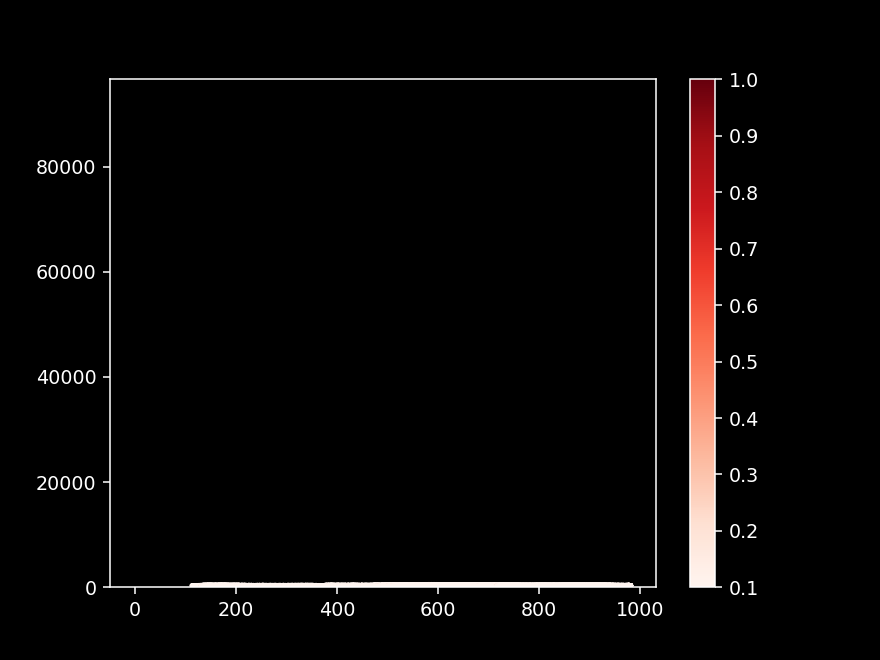

In [104]:
#scaler = MinMaxScaler().fit(df.factors[0].values[:, 1].reshape(-1, 2))
#norm_zero = scaler.transform(df.factors[0].values[:, 1].reshape(-1, 2)).reshape(-1, 1)
#norm_zero = norm_zero[np.where(norm_zero<0.1)] == 0

plt.style.use('dark_background')
#fig1, ax1 = plt.subplots(figsize=(5, 5)) #Component 0
#ax1.patch.set_facecolor('black')
plt.scatter(Cell[:, 0], Cell[:, 1], s=2, c=norm_zero[:, 0], cmap='Reds')
plt.clim(0.1, 1)
plt.colorbar()

plt.show()

<IPython.core.display.Javascript object>


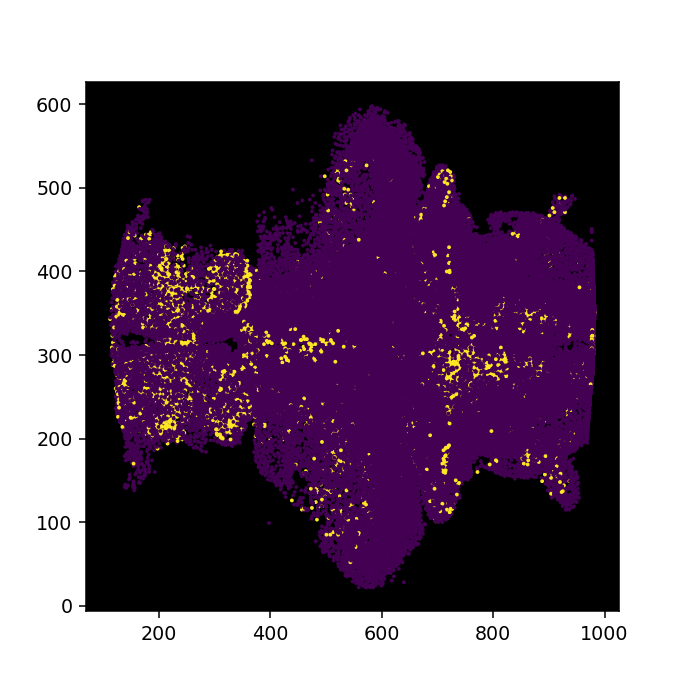

In [71]:
scaler = MinMaxScaler().fit(df.factors[0].values[:, 13].reshape(-1, 2))
norm_zero = scaler.transform(df.factors[0].values[:, 13].reshape(-1, 2)).reshape(-1, 1)

fig1, ax1 = plt.subplots(figsize=(5, 5)) #Component 12
ax1.patch.set_facecolor('black')
ax1.scatter(Cell[:, 0], Cell[:, 1], s=1, c=norm_zero[:, 0]>.05)

<IPython.core.display.Javascript object>


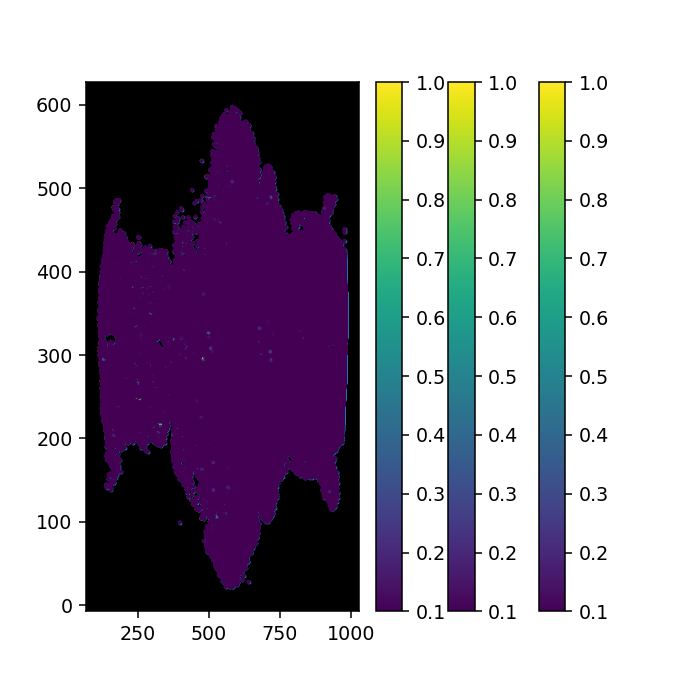

In [72]:
scaler = MinMaxScaler().fit(df.factors[0].values[:, 3].reshape(-1, 2))
norm_zero = scaler.transform(df.factors[0].values[:, 3].reshape(-1, 2)).reshape(-1, 1)

fig1, ax1 = plt.subplots(figsize=(5, 5)) #Component 2
ax1.patch.set_facecolor('black')
ax1.scatter(Cell[:, 0], Cell[:, 1], s=1, c=norm_zero[:, 0]>.05)

In [ ]:
# Fit ensembles of tensor decompositions.
methods = (
  'cp_als',    # fits unconstrained tensor decomposition.
  'ncp_bcd')   # fits nonnegative tensor decomposition.
  #'ncp_hals',  # fits nonnegative tensor decomposition.


max_rank = 30 #Define max rank
ensembles = {}
ensembles['ncp_bcd'] = tt.Ensemble(fit_method='ncp_bcd', fit_options=dict(tol=1e-4))
ensembles['ncp_bcd'].fit(real_stim, ranks=17, replicates=1)
#for m in methods:
#    ensembles[m] = tt.Ensemble(fit_method=m, fit_options=dict(tol=1e-4)) 
#    ensembles[m].fit(real_stim, ranks=range(1, 30), replicates=10)

In [18]:
bcd_obj = {}
for i in range(1, 30):
    bcd_obj[i] = ensembles['ncp_bcd'].objectives(i)

In [16]:
cp_obj, bcd_obj, hals_obj = np.zeros((max_rank, 2)), np.zeros((max_rank, 2)), np.zeros((max_rank, 2))

for m in methods:
    for i in range(1, 29):
        #if m == 'cp_als':
            #cp_obj[i, 0] = i
            #cp_obj[i, 1] = ensembles[m].objectives(i)
        if m == 'ncp_bcd':
            bcd_obj[i, 0] = i
            bcd_obj[i, 1] = ensembles[m].objectives(i)
        if m == 'ncp_hals':
            hals_obj[i, 0] = i
            hals_obj[i, 1] = ensembles[m].objectives(i)

ValueError: setting an array element with a sequence.

In [ ]:
#Plot the model Error score
fig1, ax1 = plt.subplots(figsize=(10, 10))
#ax1.plot(hals_obj[1:-1, 0], hals_obj[1:-1, 1], label='NCP_HALS', c='blue')
ax1.plot(bcd_obj[1:-1, 0], bcd_obj[1:-1, 1], label='NCP_BCD', c='red')
#ax1.plot(cp_obj[1:-1, 0], cp_obj[1:-1, 1], label='CP_ALS', c='black')
#ax1.scatter(hals_obj[1:-1, 0], hals_obj[1:-1, 1], c='blue', s=10)
ax1.scatter(bcd_obj[1:-1, 0], bcd_obj[1:-1, 1],  c='red', s=10)
#ax1.scatter(cp_obj[1:-1, 0], cp_obj[1:-1, 1], c='black', s=10)
ax1.set_xlabel('model rank')
ax1.set_ylabel('Objective')
ax1.set_ylim([0, 1.1])
plt.title('Model Error score')
ax1.legend()

plt.savefig('Model Error score', dpi=600)

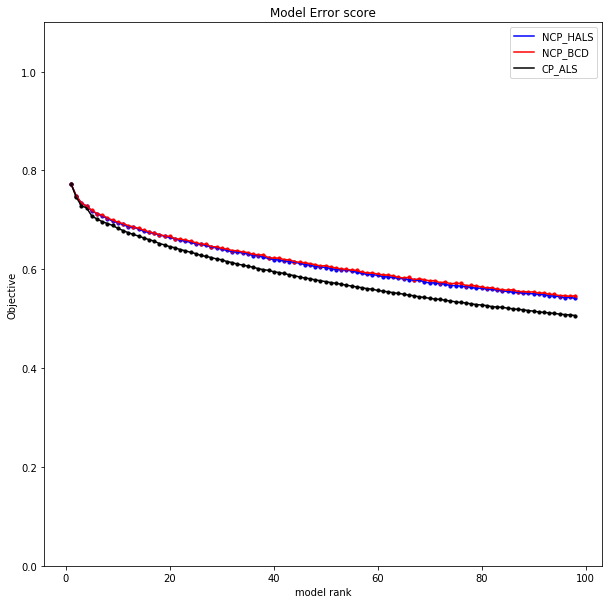

In [521]:
#Plot the model Error score
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.plot(hals_obj[1:-1, 0], hals_obj[1:-1, 1], label='NCP_HALS', c='blue')
ax1.plot(bcd_obj[1:-1, 0], bcd_obj[1:-1, 1], label='NCP_BCD', c='red')
ax1.plot(cp_obj[1:-1, 0], cp_obj[1:-1, 1], label='CP_ALS', c='black')
ax1.scatter(hals_obj[1:-1, 0], hals_obj[1:-1, 1], c='blue', s=10)
ax1.scatter(bcd_obj[1:-1, 0], bcd_obj[1:-1, 1],  c='red', s=10)
ax1.scatter(cp_obj[1:-1, 0], cp_obj[1:-1, 1], c='black', s=10)
ax1.set_xlabel('model rank')
ax1.set_ylabel('Objective')
ax1.set_ylim([0, 1.1])
plt.title('Model Error score')
ax1.legend()

plt.savefig('Model Error score', dpi=600)

In [95]:
#Calculate model similarity
cp_sim1, bcd_sim1, hals_sim1 = np.zeros((30, 10)), np.zeros((30, 10)), np.zeros((30, 10))

repli=range(1, 10)
ranks=range(1, 30)
for i in range(1, len(ranks)):
    r0, r1 = ranks[i-1], ranks[i]
    for j in repli:
        U = ensembles['ncp_bcd'].results[r0][j].factors
        V = ensembles['ncp_bcd'].results[r1][j].factors
        #if m == 'cp_als':
            #cp_sim1[i, 0] = i
            #cp_sim1[i, 1] = tt.kruskal_align(U, V, permute_U=True, permute_V=True)
        #if m == 'ncp_bcd':
        bcd_sim1[i, 0] = i
        bcd_sim1[i, j] = tt.kruskal_align(U, V, permute_U=True, permute_V=True)
        #if m == 'ncp_hals':
            #hals_sim1[i, 0] = i
            #hals_sim1[i, 1] = tt.kruskal_align(U, V, permute_U=True, permute_V=True)

In [251]:
mean_obj= []
for i in range(1, 30):
    mean_obj.append(bcd_obj[i])
mean_obj1 = np.mean(mean_obj)

In [312]:
bcd_sim1

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.95161593,  0.94511233,  0.94492133,  0.94087756,
         0.94148576,  0.94132025,  0.94257866,  0.93999727,  0.93947758],
       [ 2.        ,  0.97688651,  0.98413588,  0.97417208,  0.95938884,
         0.95602274,  0.95850876,  0.95951552,  0.96037761,  0.95460864],
       [ 3.        ,  0.98658148,  0.96241579,  0.97749772,  0.98305626,
         0.98068344,  0.98278816,  0.97026054,  0.96603095,  0.97100292],
       [ 4.        ,  0.95994856,  0.96337659,  0.97526134,  0.9628683 ,
         0.93590313,  0.96089734,  0.87068274,  0.89840557,  0.96314134],
       [ 5.        ,  0.97371802,  0.95851048,  0.93096331,  0.95205164,
         0.91118151,  0.94988827,  0.91176773,  0.91604944,  0.91407671],
       [ 6.        ,  0.93654783,  0.90502197,  0.92770839,  0.92350005,
         0.88673262,  0.89423033,  0.90224908

In [87]:
mean_sim = []
for i in range(1, 29):
    mean_sim.append(np.mean(ensembles['ncp_bcd'].similarities(i)))
    print(i, mean_sim[i])

IndexError: list index out of range

In [225]:
%matplotlib inline

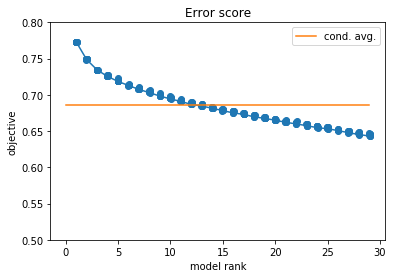

In [271]:
tt.plot_objective(ensembles['ncp_bcd'])
plt.ylim([0.5, 0.8])
plt.plot(np.arange(30), np.repeat(mean_obj1, 30), label='cond. avg.')
plt.legend()
plt.title('Error score')
plt.savefig('Error score real.png', dpi=600)

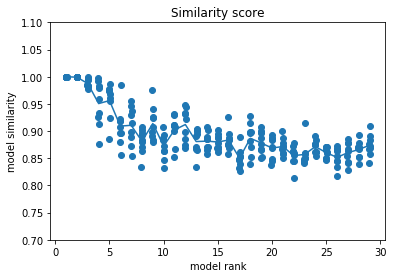

In [275]:
_=tt.plot_similarity(ensembles['ncp_bcd'])
plt.ylim([0.7, 1.1])
plt.title('Similarity score')
plt.savefig('Similarity score_real.png', dpi=600)

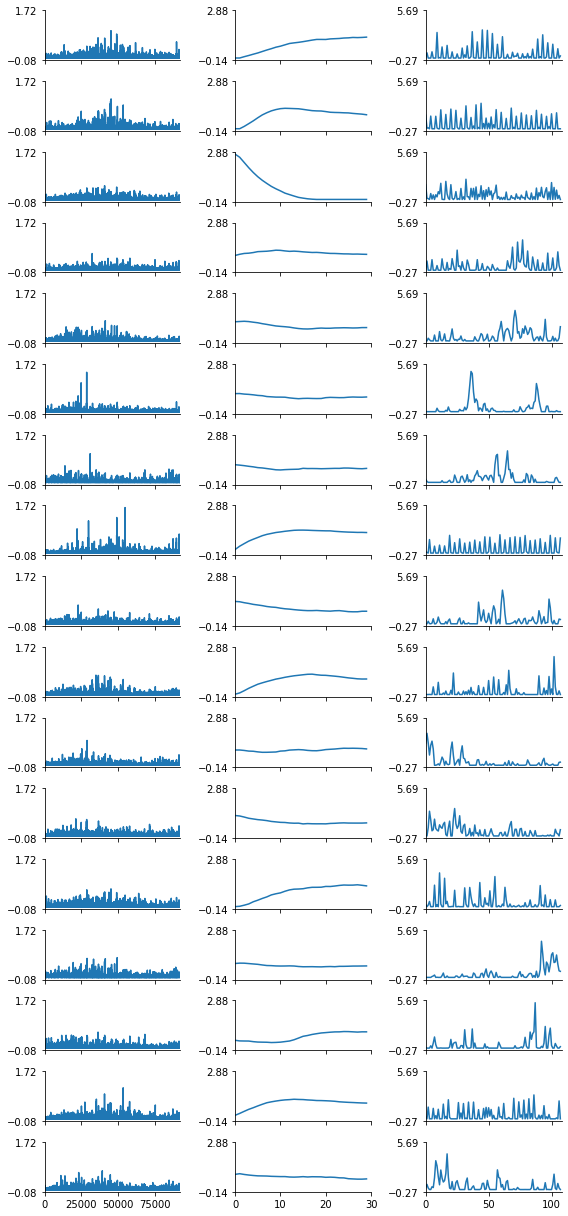

In [315]:
_=tt.plot_factors(ensembles['ncp_bcd'].factors(17)[7])
#plt.savefig('10_1 ncp_bcd.png', dpi=600)

In [296]:
# Making each stim type matrix
stim_1, stim_2, stim_3 = [], [], []
for i in range(0, 27):
    stim_1.append(4*i+1)
    stim_2.append(4*i+3)
for i in range(0, 54):
    stim_3.append(2*i)

In [ ]:
plt.plot(np.mean(np.mean(real_stim[:, :, stim_1], axis=1), axis=0))

In [35]:
#Plot the model similarity
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(hals_sim1[1:-1, 0], hals_sim1[1:-1, 1], label='NCP_HALS', c='blue')
ax.plot(bcd_sim1[1:-1, 0], bcd_sim1[1:-1, 1], label='NCP_BCD', c='red')
ax.plot(cp_sim1[1:-1, 0], cp_sim1[1:-1, 1], label='CP_ALS', c='black')
ax.scatter(hals_sim1[1:-1, 0], hals_sim1[1:-1, 1], c='blue', s=10)
ax.scatter(bcd_sim1[1:-1, 0], bcd_sim1[1:-1, 1],  c='red', s=10)
ax.scatter(cp_sim1[1:-1, 0], cp_sim1[1:-1, 1], c='black', s=10)
ax.set_xlabel('model rank')
ax.set_ylabel('model similarity')
ax.set_ylim([0, 1.1])
plt.title('Model Similarity')
ax.legend()

1
2
3
4
5
6
7
8
9


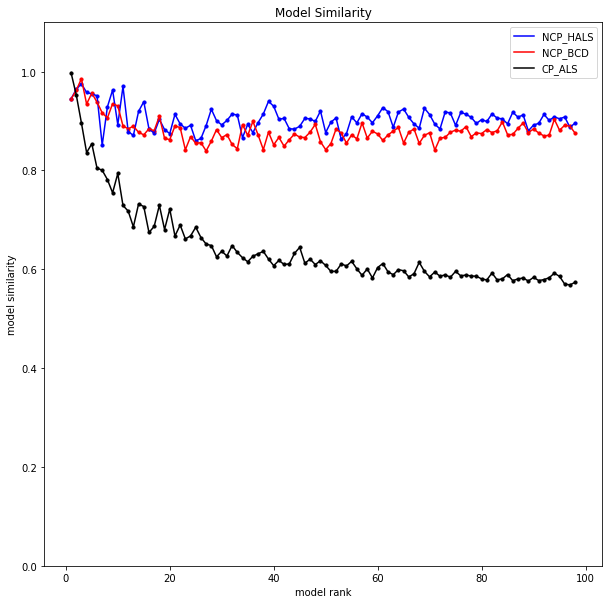

In [221]:
#Plot the model similarity
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(hals_sim1[1:-1, 0], hals_sim1[1:-1, 1], label='NCP_HALS', c='blue')
ax.plot(bcd_sim1[1:-1, 0], bcd_sim1[1:-1, 1], label='NCP_BCD', c='red')
ax.plot(cp_sim1[1:-1, 0], cp_sim1[1:-1, 1], label='CP_ALS', c='black')
ax.scatter(hals_sim1[1:-1, 0], hals_sim1[1:-1, 1], c='blue', s=10)
ax.scatter(bcd_sim1[1:-1, 0], bcd_sim1[1:-1, 1],  c='red', s=10)
ax.scatter(cp_sim1[1:-1, 0], cp_sim1[1:-1, 1], c='black', s=10)
ax.set_xlabel('model rank')
ax.set_ylabel('model similarity')
ax.set_ylim([0, 1.1])
plt.title('Model Similarity')
ax.legend()

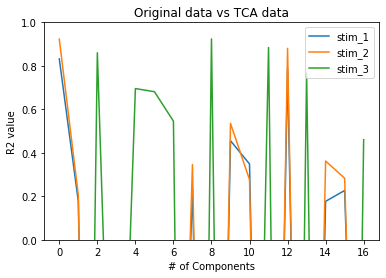

In [393]:
#Calculate R2 value between original data and TCA-data under normalized condition
mean_stim1 = np.mean(np.mean(real_stim[:, :, stim_1], axis=2), axis=0)
mean_stim2 = np.mean(np.mean(real_stim[:, :, stim_2], axis=2), axis=0)
mean_stim3 = np.mean(np.mean(real_stim[:, :, stim_3], axis=2), axis=0)

scaler1 = MinMaxScaler().fit(mean_stim1.reshape(-1, 2))
norm_stim1 = scaler1.transform(mean_stim1.reshape(-1, 2)).reshape(-1, 1)

scaler2 = MinMaxScaler().fit(mean_stim2.reshape(-1, 2))
norm_stim2 = scaler2.transform(mean_stim2.reshape(-1, 2)).reshape(-1, 1)

scaler3 = MinMaxScaler().fit(mean_stim3.reshape(-1, 2))
norm_stim3 = scaler3.transform(mean_stim3.reshape(-1, 2)).reshape(-1, 1)

norm_list = [norm_stim1, norm_stim2, norm_stim3]

r2_mat1 = np.zeros((17, 3))
for j in range(0, 3):
    for i in range(0, 17):
        stim_1_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, i]
        scaler0 = MinMaxScaler().fit(stim_1_candi.reshape(-1, 2))
        norm_candi1 = scaler0.transform(stim_1_candi.reshape(-1, 2)).reshape(-1, 1)
        
        r2_val = r2_score(norm_candi1, norm_list[j])
        r2_mat1[i, j] = r2_val
        
plt.plot(r2_mat[:,  0], label='stim_1')
plt.plot(r2_mat[:,  1], label='stim_2')
plt.plot(r2_mat[:,  2], label='stim_3')
plt.legend()
plt.ylim([0,  1])
plt.xlabel('# of Components')
plt.ylabel('R2 value')
plt.title('Original data vs TCA data')
plt.savefig('R2value_comparison.png', dpi=600)
plt.show()

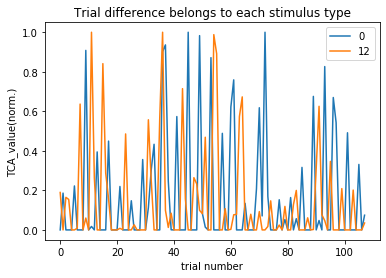

In [410]:
#Distinguish which component belongs to which stim_type 1, 2
scaler_0 = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 0].reshape(-1, 2))
norm_0 = scaler_0.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 0].reshape(-1, 2)).reshape(-1, 1)

scaler_12 = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 12].reshape(-1, 2))
norm_12 = scaler_12.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 12].reshape(-1, 2)).reshape(-1, 1)

plt.plot(norm_0, label='0')
plt.plot(norm_12, label='12')
plt.legend()
plt.xlabel('trial number')
plt.ylabel('TCA_value(norm.)')
plt.title('Trial difference belongs to each stimulus type')
#plt.xlim([0, 20])
plt.savefig('Trial difference belongs to each stimulus type.png', dpi=600)


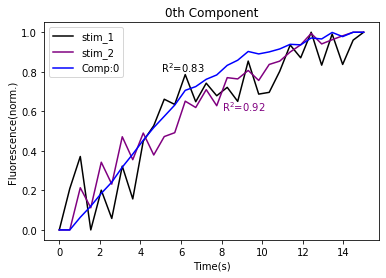

In [467]:
#R2 representing plot(Stim1, 2 vs Comp:0)
stim_1_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, 0]
scaler0 = MinMaxScaler().fit(stim_1_candi.reshape(-1, 2))
norm_candi1 = scaler0.transform(stim_1_candi.reshape(-1, 2)).reshape(-1, 1)

r2_val = r2_score(norm_candi1, norm_list[j])
plt.plot(np.linspace(0, 15, 30), norm_stim1, c='black', label='stim_1')
plt.plot(np.linspace(0, 15, 30), norm_stim2, c='purple', label='stim_2')

plt.plot(np.linspace(0, 15, 30), norm_candi1, c='blue', label='Comp:0')
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Fluorescence(norm.)')
plt.text(5, .8, r'$\mathregular{R^2}}$=0.83', color='black')
plt.text(8, .6, r'$\mathregular{R^2}}$=0.92', color='purple')
plt.title('0th Component')
plt.savefig('[stim1,2]comp0 R2.png', dpi=600)

In [109]:
%matplotlib widget

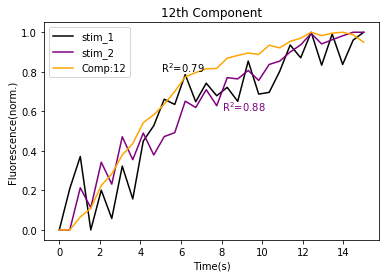

In [456]:
#R2 representing plot(Stim1, 2 vs Comp:12)
stim_1_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, 12]
scaler0 = MinMaxScaler().fit(stim_1_candi.reshape(-1, 2))
norm_candi1 = scaler0.transform(stim_1_candi.reshape(-1, 2)).reshape(-1, 1)

r2_val = r2_score(norm_candi1, norm_list[j])
plt.plot(np.linspace(0, 15, 30), norm_stim1, c='black', label='stim_1')
plt.plot(np.linspace(0, 15, 30), norm_stim2, c='purple', label='stim_2')

plt.plot(np.linspace(0, 15, 30), norm_candi1, c='Orange', label='Comp:12')
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Fluorescence(norm.)')
plt.text(5, .8, r'$\mathregular{R^2}}$=0.79', color='black')
plt.text(8, .6, r'$\mathregular{R^2}}$=0.88', color='purple')
plt.title('12th Component')

plt.savefig('[stim1,2]comp12 R2.png', dpi=600)

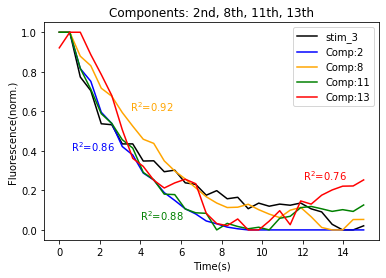

In [468]:
#R2 representing plot(Stim3 vs Comp:2, 8, 11, 13)
stim_2_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, 2]
scaler_2 = MinMaxScaler().fit(stim_2_candi.reshape(-1, 2))
norm_candi2 = scaler_2.transform(stim_2_candi.reshape(-1, 2)).reshape(-1, 1)

stim_8_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, 8]
scaler_8 = MinMaxScaler().fit(stim_8_candi.reshape(-1, 2))
norm_candi8 = scaler_8.transform(stim_8_candi.reshape(-1, 2)).reshape(-1, 1)

stim_11_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, 11]
scaler_11 = MinMaxScaler().fit(stim_11_candi.reshape(-1, 2))
norm_candi11 = scaler_11.transform(stim_11_candi.reshape(-1, 2)).reshape(-1, 1)

stim_13_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, 13]
scaler_13 = MinMaxScaler().fit(stim_13_candi.reshape(-1, 2))
norm_candi13 = scaler_13.transform(stim_13_candi.reshape(-1, 2)).reshape(-1, 1)

r2_val = r2_score(norm_candi1, norm_list[j])
plt.plot(np.linspace(0, 15, 30), norm_stim3, c='black', label='stim_3')
plt.plot(np.linspace(0, 15, 30), norm_candi2, c='blue', label='Comp:2')
plt.plot(np.linspace(0, 15, 30), norm_candi8, c='orange', label='Comp:8')
plt.plot(np.linspace(0, 15, 30), norm_candi11, c='green', label='Comp:11')
plt.plot(np.linspace(0, 15, 30), norm_candi13, c='red', label='Comp:13')

plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Fluorescence(norm.)')
plt.text(0.6, .4, r'$\mathregular{R^2}}$=0.86', color='blue')
plt.text(3.5, .6, r'$\mathregular{R^2}}$=0.92', color='orange')
plt.text(4, .05, r'$\mathregular{R^2}}$=0.88', color='green')
plt.text(12, .25, r'$\mathregular{R^2}}$=0.76', color='red')

plt.title('Components: 2nd, 8th, 11th, 13th')
plt.savefig('[stim3]comp2,8,11,13 R2.png', dpi=600)

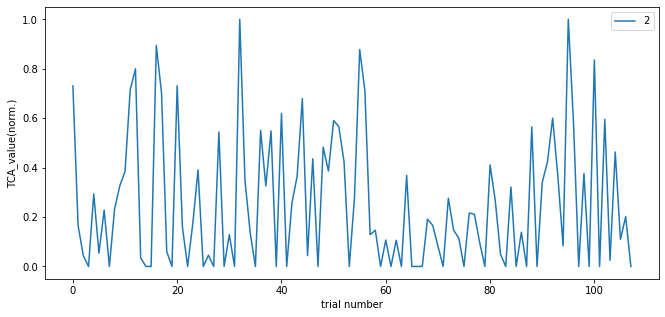

In [424]:
#Let's figure out what is different in stim 3

scaler_2 = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 2].reshape(-1, 2))
norm_2 = scaler_2.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 2].reshape(-1, 2)).reshape(-1, 1)

scaler_8 = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 8].reshape(-1, 2))
norm_8 = scaler_8.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 8].reshape(-1, 2)).reshape(-1, 1)

scaler_11 = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 11].reshape(-1, 2))
norm_11 = scaler_11.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 11].reshape(-1, 2)).reshape(-1, 1)

scaler_13 = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 13].reshape(-1, 2))
norm_13 = scaler_13.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 13].reshape(-1, 2)).reshape(-1, 1)

_, ax = plt.subplots(figsize=(11, 5))
ax.plot(norm_2, label='2')
#ax.plot(norm_8, label='8')
#ax.plot(norm_11, label='11')
#ax.plot(norm_13, label='13')
ax.legend()
ax.set_xlabel('trial number')
ax.set_ylabel('TCA_value(norm.)')
#plt.title('Trial component values belong to stim_type 3')
plt.savefig('Only 2_Trial component values belong to stim_type 3.png', dpi=600)
plt.show()

In [442]:
r2_mat

array([[ 0.83195476,  0.92281279, -5.62114368],
       [ 0.17642924,  0.20522526, -5.3333978 ],
       [-4.48266743, -4.66888995,  0.86030427],
       [-1.45653786, -1.62320224, -1.83028818],
       [-3.8869386 , -3.96193962,  0.69547185],
       [-3.17404376, -3.27073355,  0.6811744 ],
       [-2.48043448, -2.52578545,  0.54576694],
       [ 0.24140819,  0.34615043, -6.25722013],
       [-3.81845207, -3.98596711,  0.92373373],
       [ 0.45573337,  0.53546919, -5.4465551 ],
       [ 0.34862809,  0.27636413, -3.2982401 ],
       [-3.87857944, -4.03676457,  0.88441504],
       [ 0.78570635,  0.88037659, -5.87031439],
       [-3.60793864, -3.73593795,  0.76672665],
       [ 0.17691448,  0.36230603, -4.96232973],
       [ 0.22668123,  0.28316559, -5.62470197],
       [-2.48586433, -2.66355325,  0.46022816]])

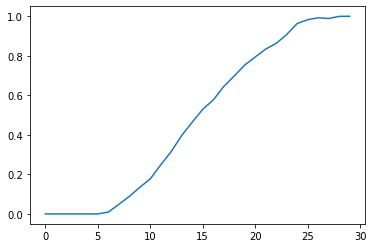

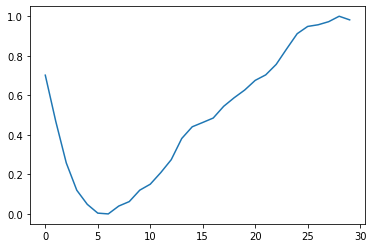

0.799228068056109

In [83]:
##Let's compare the TCA and original data(norm. averaged)
component=6
thre=0.2(threshold)

#TCA DATA normalization
TCA_data = np.zeros((30, 2))
TCA_data[:, 0] = np.arange(30)
TCA_data[:, 1] = ensembles['ncp_bcd'].factors(27)[0][1][:, comp]
scaler1 = MinMaxScaler().fit(TCA_data)
norm_TCA_data = scaler1.transform(TCA_data)
plt.figure()
_=plt.plot(norm_TCA_data[:, 1])

#Original Data normalization
sel_data = np.nonzero(ensembles['ncp_bcd'].factors(27)[0][0][:, comp]>thre)[0]
#print(sel_data)
#print(np.mean(trial_mean[sel_data, :], 0))
temp_data = np.zeros((30, 2))
temp_data[:, 0] = np.arange(30)
temp_data[:, 1] = np.mean(trial_mean[sel_data, :], 0)
scaler = MinMaxScaler().fit(temp_data)
norm_data = scaler.transform(temp_data)
plt.figure()
_=plt.plot(norm_data[:, 1])

plt.show()

#Calculate R2 value
r2_score(norm_TCA_data[:, 1], norm_data[:, 1])

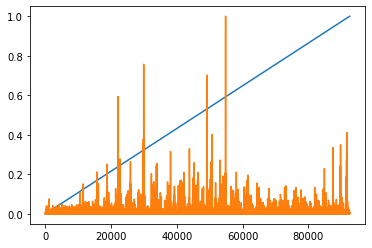

In [541]:
sample_1[:, 1] = ensembles['ncp_bcd'].factors(27)[0][0][:, 3]
scaler = MinMaxScaler().fit(sample_1)
tr_data = scaler.transform(sample_1)
sel_data = np.nonzero(tr_data[:, 1]>np.mean(tr_data[:, 1]))[0]

plt.plot(tr_data[sel_data, 1])

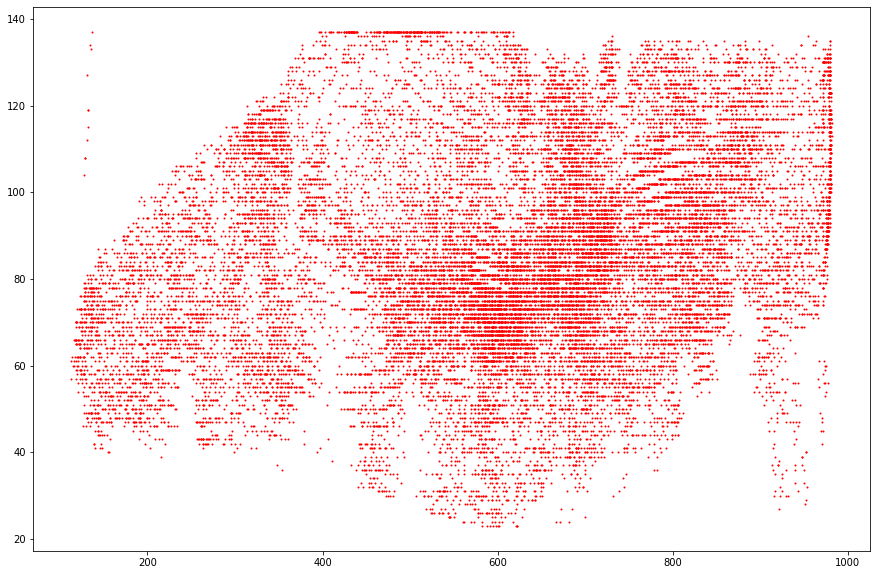

In [558]:
#Y, Z = type 2 // X = type 1
#X=Y
#Y[:, 1] = ensembles['ncp_bcd'].factors(27)[0][0][:, 8]
#scaler = MinMaxScaler().fit(Y)
_, ax = plt.subplots(figsize=(15, 10))
#sel_test1 = np.nonzero(scaler.transform(Y)[:, 1]>0.25)[0]
ax.scatter(Cell[sel_data, 0], Cell[sel_data, 2], s=1, c='red')
#ax.scatter(Cell[sel_test1, 0], Cell[sel_test1, 1], s=10, c='yellow')
#ax.scatter(Cell[sel_test2, 0], Cell[sel_test2, 1], s=10, c='black')


In [38]:
df.factors[0]

Unnamed: 0         0         1         2         3         4         5  \
0               0  0.005440  0.009481  0.005427  0.011555  0.014472  0.012153   
1               1  0.004187  0.011157  0.004607  0.012115  0.010978  0.012093   
2               2  0.003391  0.010489  0.004300  0.011949  0.010948  0.011351   
3               3  0.006250  0.009630  0.006856  0.011631  0.008697  0.012724   
4               4  0.003880  0.010195  0.005350  0.013384  0.008642  0.010623   
...           ...       ...       ...       ...       ...       ...       ...   
92533       92533  0.007902  0.012349  0.003623  0.011905  0.011516  0.015828   
92534       92534  0.007791  0.013405  0.006862  0.016443  0.012212  0.019271   
92535       92535  0.012839  0.015033  0.007510  0.012491  0.007428  0.032057   
92536       92536  0.004857  0.013201  0.001441  0.014743  0.013610  0.029487   
92537       92537  0.008523  0.014413  0.003844  0.018583  0.020787  0.025720   

              6         7         8         9        10        11        12  \
0      0.010820  0.007612  0.009853  0.007340  0.011331  0.016904  0.001286   
1      0.008520  0.010791  0.011196  0.006739  0.013305  0.010102  0.004029   
2      0.013970  0.006669  0.009179  0.008882  0.012667  0.013813  0.005955   
3      0.009910  0.011385  0.010399  0.011153  0.012391  0.011124  0.002245   
4      0.009643  0.011995  0.008623  0.014539  0.007800  0.011883  0.003492   
...         ...       ...       ...       ...       ...       ...       ...   
92533  0.005366  0.009685  0.005734  0.006258  0.015038  0.013688  0.005993   
92534  0.004987  0.010902  0.010124  0.008377  0.014849  0.019933  0.003547   
92535  0.017158  0.017888  0.010723  0.007750  0.017583  0.016344  0.000902   
92536  0.008258  0.009474  0.007144  0.005912  0.013704  0.024560  0.003734   
92537  0.002463  0.010699  0.007537  0.006137  0.012667  0.021407  0.003140   

             13        14        15        16  
0      0.012525  0.000931  0.012349  0.007168  
1      0.014211  0.000320  0.013589  0.011646  
2      0.016992  0.005083  0.012880  0.011377  
3      0.012370  0.000895  0.014339  0.011013  
4      0.012926  0.000869  0.014864  0.012317  
...         ...       ...       ...       ...  
92533  0.012455  0.005247  0.013854  0.019218  
92534  0.008941  0.000753  0.013986  0.013101  
92535  0.009226  0.000000  0.022650  0.013939  
92536  0.016656  0.000506  0.014618  0.015106  
92537  0.011324  0.000052  0.014087  0.018972  

[92538 rows x 18 columns]

In [469]:
#Reorganize the behavior(motor) pattern 
#Real_beh shape is 30x 2 x 108
real_beh = np.zeros((np.shape(real_stim)[1], 2))
real_beh[:30, 0] = Beh_seed[:30, 0]
real_beh[:30, 1] = Beh_seed[:30, 1]

for t in range (0, max_num+1):
    if t==0:
        temp = count_val[0][1]
        print(temp)
    elif count_val[t][1]-count_val[t-1][1] == 10:
        real_beh = np.dstack((real_beh, Beh_seed[temp:temp+count_val[t][1]-10, :]))
        temp += count_val[t][1]
        print(temp)
    elif count_val[t][1]-count_val[t-1][1] == -10:
        real_beh = np.dstack((real_beh, Beh_seed[temp:temp+count_val[t][1], :]))
        temp += count_val[t][1]
        print(temp)
    else:
        print("err")

30
70
100
140
170
210
240
280
310
350
380
420
450
490
520
560
590
630
660
700
730
770
800
840
870
910
940
980
1010
1050
1080
1120
1150
1190
1220
1260
1290
1330
1360
1400
1430
1470
1500
1540
1570
1610
1640
1680
1710
1750
1780
1820
1850
1890
1920
1960
1990
2030
2060
2100
2130
2170
2200
2240
2270
2310
2340
2380
2410
2450
2480
2520
2550
2590
2620
2660
2690
2730
2760
2800
2830
2870
2900
2940
2970
3010
3040
3080
3110
3150
3180
3220
3250
3290
3320
3360
3390
3430
3460
3500
3530
3570
3600
3640
3670
3710
3740
3780


In [541]:
r2_mat2 = np.zeros((6, 3))
comp_list = [0, 2, 12]
for i in range(0, len(comp_list)):
    stim_1_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, i]
    scaler0 = MinMaxScaler().fit(stim_1_candi.reshape(-1, 2))
    norm_candi1 = scaler0.transform(stim_1_candi.reshape(-1, 2)).reshape(-1, 1)
    for j in range(0, 6):
        r2_val = r2_score(norm_candi1, norm_motor[j])
        r2_mat2[j, i] = r2_val

In [540]:
r2_mat2

array([[-5.81096215, -5.89896161,  0.74639206],
       [ 0.95761021,  0.29690992, -4.115418  ],
       [ 0.98141321,  0.45647014, -4.61150832],
       [ 0.73641068, -0.08513657, -3.81552371],
       [-6.95028716, -7.56712349,  0.68791606],
       [-5.20640128, -4.91155638,  0.93601901]])

In [542]:
r2_mat2

array([[-3.19658795, -4.7926453 ,  0.82423057],
       [ 0.95973527,  0.08991955, -4.46559221],
       [ 0.98265901,  0.30896794, -4.88900176],
       [ 0.75757033, -0.36002758, -3.98188987],
       [-3.62807803, -5.79607604,  0.79564658],
       [-3.74775329, -5.16247928,  0.94494562]])

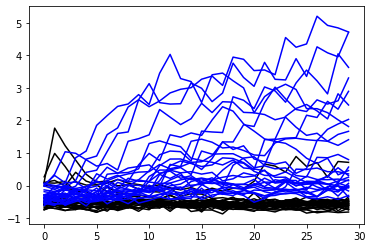

In [480]:
scaler_motor0 = MinMaxScaler().fit(real_beh[:, 0, stim_1].reshape(-1, 2))
norm_motor0 = scaler_2.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 2].reshape(-1, 2)).reshape(-1, 1)

scaler_motor1 = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 2].reshape(-1, 2))
norm_motor1 = scaler_2.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 2].reshape(-1, 2)).reshape(-1, 1)

_=plt.plot(np.arange(30), real_beh[:, 0, stim_1], c='black')
_=plt.plot(np.arange(30), real_beh[:, 1, stim_1], c='blue')
#_=plt.plot(np.arange(30), real_beh[:, 1, stim_2], c='blue')
#_=plt.plot(np.arange(30), real_beh[:, 1, stim_3], c='red')

In [494]:
mean_motor1L = np.mean(real_beh[:, 0, stim_1], axis=1)
mean_motor1R = np.mean(real_beh[:, 1, stim_1], axis=1)
mean_motor2L = np.mean(real_beh[:, 0, stim_2], axis=1)
mean_motor2R = np.mean(real_beh[:, 1, stim_2], axis=1)
mean_motor3L = np.mean(real_beh[:, 0, stim_3], axis=1)
mean_motor3R = np.mean(real_beh[:, 1, stim_3], axis=1)

norm_motor = {} 
mean_motor_list = [mean_motor1L, mean_motor1R, mean_motor2L, mean_motor2R, mean_motor3L, mean_motor3R]
for i in range(0, len(mean_motor_list)):
    scaler_motor = MinMaxScaler().fit(mean_motor_list[i].reshape(-1, 2))
    norm_motor[i] = scaler_motor.transform(mean_motor_list[i].reshape(-1, 2)).reshape(-1, 1)

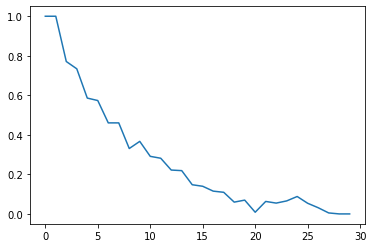

In [518]:
plt.plot(norm_motor[5])

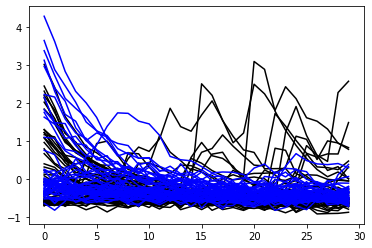

In [483]:
_=plt.plot(np.arange(30), real_beh[:, 0, stim_3], c='black')
_=plt.plot(np.arange(30), real_beh[:, 1, stim_3], c='blue')

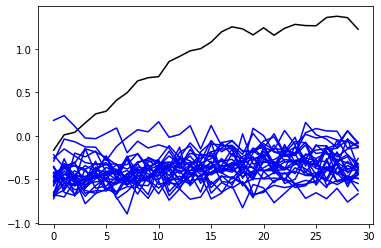

In [489]:
_=plt.plot(np.arange(30), real_beh[:, 0, stim_2], c='black')
_=plt.plot(np.arange(30), real_beh[:, 1, stim_2], c='blue')

In [488]:
np.shape(np.mean(real_beh[:, 0, stim_2], axis=1))

(30,)

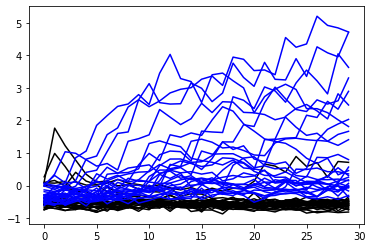

In [481]:
_=plt.plot(np.arange(30), real_beh[:, 0, stim_1], c='black')
_=plt.plot(np.arange(30), real_beh[:, 1, stim_1], c='blue')

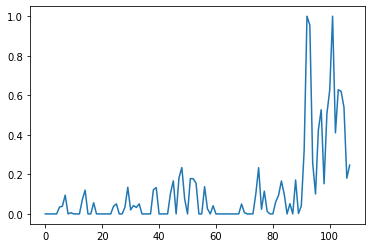

In [536]:
scaler_test = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 13].reshape(-1, 2))
norm_test = scaler_test.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 13].reshape(-1, 2)).reshape(-1, 1)
plt.plot(norm_test)

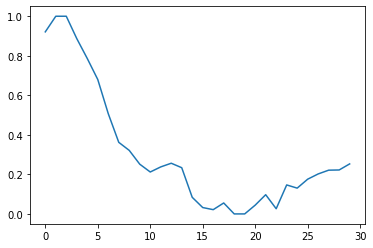

In [537]:
scaler_test = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][1][:, 13].reshape(-1, 2))
norm_test = scaler_test.transform(ensembles['ncp_bcd'].factors(17)[7][1][:, 13].reshape(-1, 2)).reshape(-1, 1)
plt.plot(norm_test)

In [111]:
mask_10 = np.random.rand(np.shape(real_stim)[0], np.shape(real_stim)[1], np.shape(real_stim)[2]) >.1
mask_90 = np.random.rand(np.shape(real_stim)[0], np.shape(real_stim)[1], np.shape(real_stim)[2]) >.9

In [114]:
U_10.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
R = range(8, 20)
# Fit nonnegative tensor decomposition.
U_90, U_10 = {}, {}
for r in R:
    U_90[r] = tt.ncp_hals(real_stim, rank=r, mask=mask_90, verbose=True)
    U_10[r] = tt.ncp_hals(real_stim, rank=r, mask=mask_10, verbose=True)

NCP_HALS: iteration 1, objective 0.4731887512693919, improvement inf.
NCP_HALS: iteration 2, objective 0.4621707278787369, improvement 0.011018023390654996.
NCP_HALS: iteration 3, objective 0.4527275629314384, improvement 0.009443164947298521.
NCP_HALS: iteration 4, objective 0.44494706674751494, improvement 0.007780496183923458.
NCP_HALS: iteration 5, objective 0.43861147027956426, improvement 0.006335596467950677.
NCP_HALS: iteration 6, objective 0.43340986441860635, improvement 0.005201605860957914.
NCP_HALS: iteration 7, objective 0.4290826247198067, improvement 0.0043272396987996675.
NCP_HALS: iteration 8, objective 0.42540454906396113, improvement 0.0036780756558455474.
NCP_HALS: iteration 9, objective 0.422211875162258, improvement 0.003192673901703136.
NCP_HALS: iteration 10, objective 0.41940626428069155, improvement 0.002805610881566445.
NCP_HALS: iteration 11, objective 0.41691498484655815, improvement 0.002491279434133409.
NCP_HALS: iteration 12, objective 0.414686773475519

In [90]:
# Compute model prediction for full tensor.
Xhat = U.factors.full()

# Compute norm of residuals on training and test sets.
train_error = np.linalg.norm(Xhat[mask] - X[mask]) / np.linalg.norm(X[mask])
test_error = np.linalg.norm(Xhat[~mask] - X[~mask]) / np.linalg.norm(X[~mask])

# Print result.
print("TRAINING ERROR:", train_error / np.linalg.norm(X[mask]))
print("TESTING ERROR: ", test_error / np.linalg.norm(X[~mask]))


TypeError: '<=' not supported between instances of 'range' and 'int'

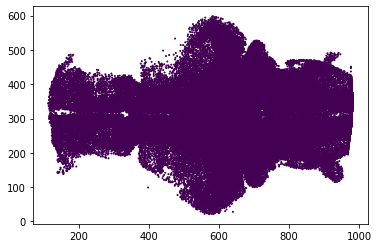

In [656]:
_=plt.scatter(X[:, 0], X[:, 1], s=1, c=clustering.labels_)

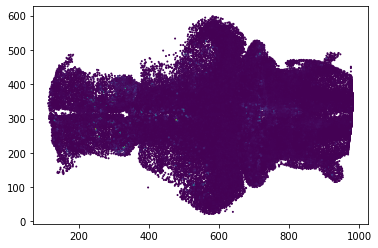

In [624]:
_=plt.scatter(X[:, 0], X[:, 1], s=1, c=norm_00[:, 0]) # No preference

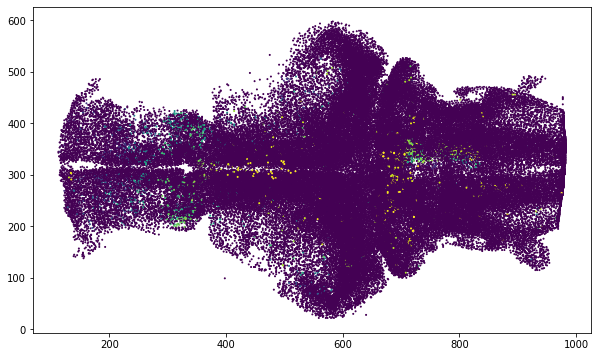

In [634]:
fig, ax = plt.subplots(figsize=(10, 6)) #Component: 0
ax.scatter(X[:, 0], X[:, 1], s=1, c=clustering.labels_)

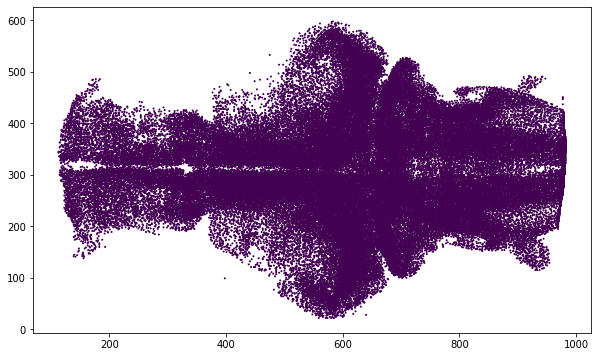

In [640]:
fig, ax = plt.subplots(figsize=(10, 6)) #Component: 0
ax.scatter(X[:, 0], X[:, 1], s=1, c=clustering.labels_)

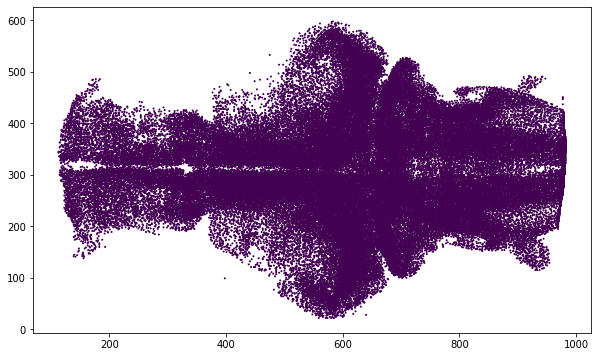

In [636]:
fig, ax = plt.subplots(figsize=(10, 6)) #Component: 12
ax.scatter(X[:, 0], X[:, 1], s=1, c=clustering.labels_)

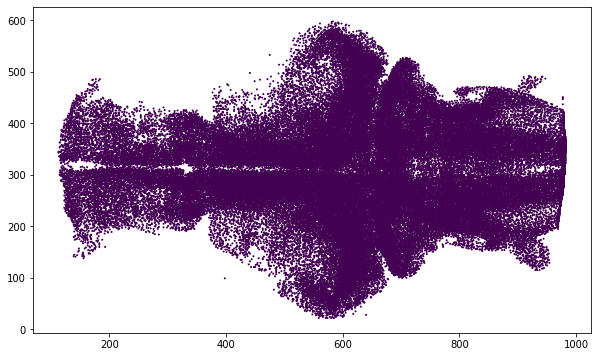

In [638]:
fig, ax = plt.subplots(figsize=(10, 6)) #Component: 2
ax.scatter(X[:, 0], X[:, 1], s=1, c=clustering.labels_)

In [625]:
np.unique(clustering.labels_)

array([  -1,    0,    1, ..., 2137, 2138, 2139], dtype=int64)

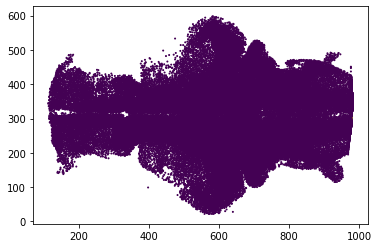

In [623]:
clustering1 = DBSCAN().fit(X)
_=plt.scatter(X[:, 0], X[:, 1], s=1, c=clustering1.labels_)

In [610]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1, 20)
  
X = Cell

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(Cell, sample_weight=norm_00[:, 0])     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

In [614]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(Cell, sample_weight=norm_00[:, 0])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

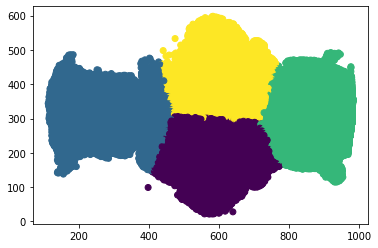

In [616]:
_=plt.scatter(Cell[:, 0], Cell[:, 1], c=kmeanModel.labels_)

1 : 207.8165086308704
2 : 151.63119996839342
3 : 121.63759957108815
4 : 101.03544981696626
5 : 90.11736481916697
6 : 83.7103181833015
7 : 78.7275499926042
8 : 73.61648031567503
9 : 68.87912340971657
10 : 66.95688061870354
11 : 64.33989921246864
12 : 61.8106117755205
13 : 60.504276344533345
14 : 58.15180268743239
15 : 56.612371444753244
16 : 55.11008425007715
17 : 53.42120960531076
18 : 52.31757185742686
19 : 50.93040088486382


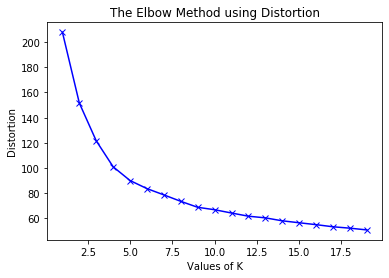

In [611]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val))
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

1 : 5389460745.958581
2 : 2123206282.3515086
3 : 1421014137.6610258
4 : 1029413154.3176388
5 : 800916573.2875967
6 : 677808335.8339075
7 : 598179864.30951
8 : 535608745.22271425
9 : 480468625.74570584
10 : 433141195.32573664
11 : 396213318.7812913
12 : 364780223.0307192
13 : 336106196.508953
14 : 307673185.0309224
15 : 291620361.1163001
16 : 277605860.4587902
17 : 264590281.536315
18 : 252034999.03234553
19 : 241104570.09549937


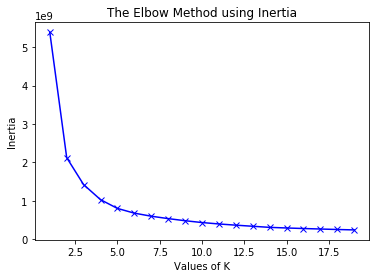

In [612]:
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val))
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [617]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1, 20)
  
X = Cell

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(Cell)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

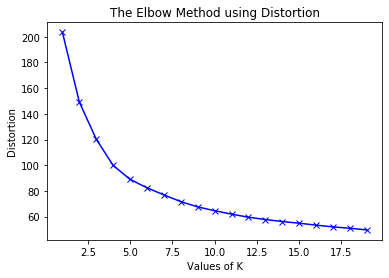

In [618]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

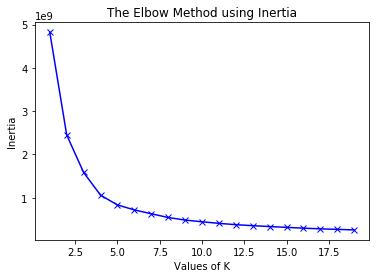

In [619]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [574]:
scaler = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][0][:, 0].reshape(-1, 2))
norm_00 = scaler.transform(ensembles['ncp_bcd'].factors(17)[7][0][:, 0].reshape(-1, 2)).reshape(-1, 1)
norm_00

array([[0.00742061],
       [0.00423257],
       [0.00462517],
       ...,
       [0.01297814],
       [0.00662633],
       [0.00861513]])

In [546]:
df_1 = pd.DataFrame(ensembles['ncp_bcd'].factors(17)[7][0])
df_2 = pd.DataFrame(ensembles['ncp_bcd'].factors(17)[7][1])
df_3 = pd.DataFrame(ensembles['ncp_bcd'].factors(17)[7][2])

df_1.to_csv('17_7_1.csv')
df_2.to_csv('17_7_2.csv')
df_3.to_csv('17_7_3.csv')

In [555]:
a = tt.KTensor((df_1, df_2, df_3))

In [215]:
df = pd.DataFrame()
df['cp_err'] = cp_obj[0:-1, 1]
df['bcd_err'] = bcd_obj[0:-1, 1]
df['hals_err'] = hals_obj[0:-1, 1]
df['cp_sim'] = cp_sim[0:-1, 1]
df['bcd_sim'] = bcd_sim[0:-1, 1]
df['hals_sim'] = hals_sim[0:-1, 1]

In [217]:
df.to_csv('err_sim.csv')

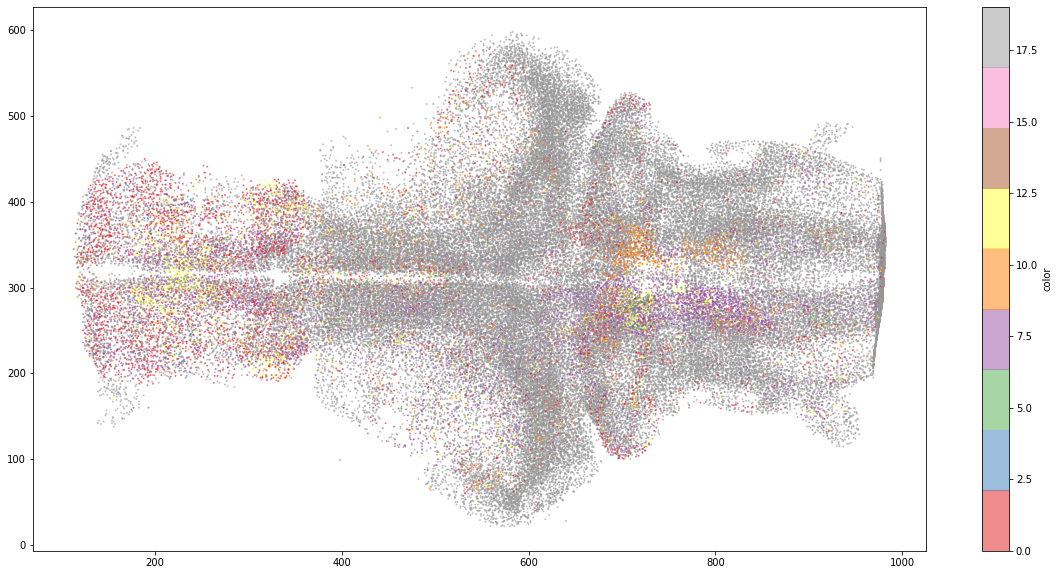

In [43]:
plt.figure(figsize=(20, 10))
plt.scatter(Cell[:, 0], Cell[:, 1], c=kmeans_all.labels_, s=1, cmap=plt.cm.Set1, alpha=0.5)
plt.colorbar(label='color')
#plt.savefig('../../assets/images/markdown_img/180601_colorbar_numeric_data.svg')
plt.show()

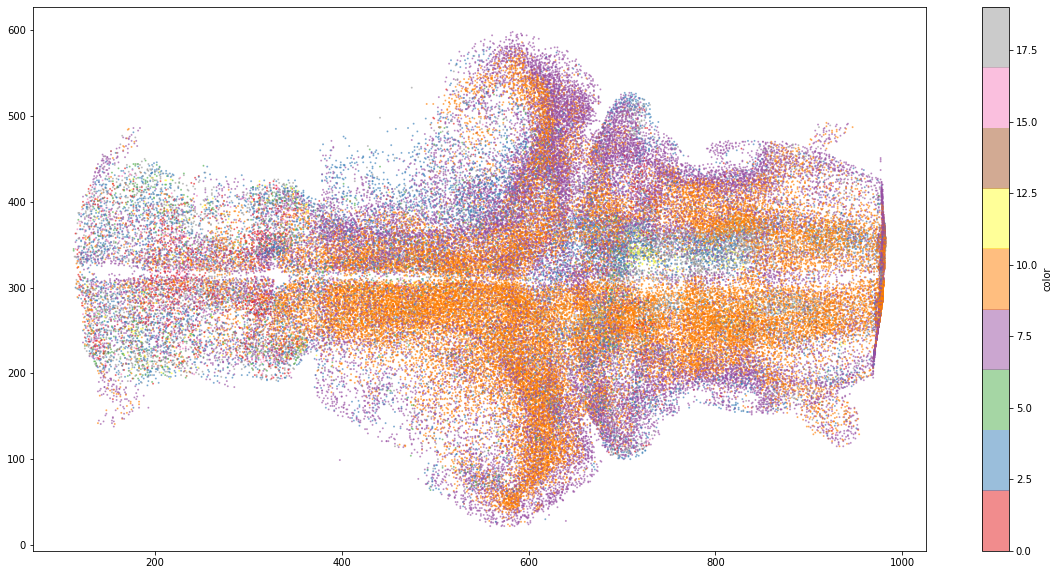

In [32]:
plt.figure(figsize=(20, 10))
plt.scatter(Cell[:, 0], Cell[:, 1], c=kmeans.labels_, s=1, cmap=plt.cm.Set1, alpha=0.5)
plt.colorbar(label='color')
#plt.savefig('../../assets/images/markdown_img/180601_colorbar_numeric_data.svg')
plt.show()